# Tarea Final

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# https://www.kaggle.com/competitions/playground-series-s3e26/data?select=train.csv
# Load Dataset
df = pd.read_csv('data/train.csv')
df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [67]:
from sklearn.model_selection import train_test_split

# Drop ID column
df.drop(columns=['id'], inplace=True)

# Use train_test_split to split the DataFrame
train_df, test_df = train_test_split(df, test_size=0.2)


## EDA

In [68]:
train_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
5664,1785,Placebo,12779,F,N,Y,N,N,0.8,360.0,3.95,52.0,4332.0,53.00,164.0,327.0,10.6,2.0,C
2404,2330,Placebo,9598,F,N,Y,N,N,0.8,636.0,3.90,35.0,944.0,93.00,84.0,293.0,11.0,4.0,C
2358,4079,D-penicillamine,17774,F,N,N,N,N,0.7,390.0,3.54,73.0,676.0,93.00,69.0,200.0,9.1,3.0,C
1927,1234,Placebo,22156,F,N,N,Y,N,1.0,372.0,3.25,108.0,1190.0,140.00,55.0,248.0,10.6,3.0,C
1754,130,Placebo,20510,F,N,Y,N,Y,17.9,395.0,2.94,172.0,6064.8,227.04,191.0,190.0,11.4,4.0,D


In [69]:
train_df.shape

(6324, 19)

In [70]:
test_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
2429,1320,Placebo,12641,F,N,Y,N,N,8.5,257.0,3.95,38.0,1812.0,97.65,90.0,202.0,9.5,2.0,C
7494,552,Placebo,12227,F,N,N,N,N,3.2,242.0,3.43,143.0,1406.0,141.05,80.0,151.0,10.8,3.0,CL
5305,1932,D-penicillamine,14772,F,N,N,Y,S,1.3,356.0,3.72,116.0,1636.0,86.80,137.0,381.0,10.1,4.0,C
1981,3853,D-penicillamine,20891,F,N,N,N,N,2.1,331.0,3.60,20.0,2148.0,128.65,98.0,344.0,10.7,3.0,D
1203,1735,Placebo,23585,F,N,Y,Y,N,3.2,262.0,3.54,13.0,815.0,89.90,86.0,240.0,9.8,4.0,C


In [71]:
test_df.shape

(1581, 19)

In [72]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6324 entries, 5664 to 7672
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         6324 non-null   int64  
 1   Drug           6324 non-null   object 
 2   Age            6324 non-null   int64  
 3   Sex            6324 non-null   object 
 4   Ascites        6324 non-null   object 
 5   Hepatomegaly   6324 non-null   object 
 6   Spiders        6324 non-null   object 
 7   Edema          6324 non-null   object 
 8   Bilirubin      6324 non-null   float64
 9   Cholesterol    6324 non-null   float64
 10  Albumin        6324 non-null   float64
 11  Copper         6324 non-null   float64
 12  Alk_Phos       6324 non-null   float64
 13  SGOT           6324 non-null   float64
 14  Tryglicerides  6324 non-null   float64
 15  Platelets      6324 non-null   float64
 16  Prothrombin    6324 non-null   float64
 17  Stage          6324 non-null   float64
 18  Status    

In [73]:
# Displays the total number of null values per column and the % of those within the column of the provided DataFrame
# In case a col name is parsed as a parameter, only that column will be printed
def null_percentage(df: pd.DataFrame, col: str = None):
    total_rows = len(df)
    df_cols = df.columns
    if col in df_cols:
        null_count = df[col].isnull().sum()
        percentage_null = (null_count / total_rows) * 100
        print(f"{col}: total -> {null_count}, percentage -> {percentage_null:.2f}%")
    elif (col not in df_cols) & (col is not None):
        print(f"Column \"{col}\" not in Dataframe")
    else:
        for col in df.columns:
            null_count = df[col].isnull().sum()
            percentage_null = (null_count / total_rows) * 100
            print(f"{col}: total -> {null_count}, percentage -> {percentage_null:.2f}%")

In [74]:
null_percentage(train_df)

N_Days: total -> 0, percentage -> 0.00%
Drug: total -> 0, percentage -> 0.00%
Age: total -> 0, percentage -> 0.00%
Sex: total -> 0, percentage -> 0.00%
Ascites: total -> 0, percentage -> 0.00%
Hepatomegaly: total -> 0, percentage -> 0.00%
Spiders: total -> 0, percentage -> 0.00%
Edema: total -> 0, percentage -> 0.00%
Bilirubin: total -> 0, percentage -> 0.00%
Cholesterol: total -> 0, percentage -> 0.00%
Albumin: total -> 0, percentage -> 0.00%
Copper: total -> 0, percentage -> 0.00%
Alk_Phos: total -> 0, percentage -> 0.00%
SGOT: total -> 0, percentage -> 0.00%
Tryglicerides: total -> 0, percentage -> 0.00%
Platelets: total -> 0, percentage -> 0.00%
Prothrombin: total -> 0, percentage -> 0.00%
Stage: total -> 0, percentage -> 0.00%
Status: total -> 0, percentage -> 0.00%


* No null values in the training set

### Numerical Cols

In [83]:
numeric_cols = train_df.select_dtypes(include='number')
print(len(numeric_cols.columns))

12


In [88]:
test_df["Age"].max()/365

78.4931506849315

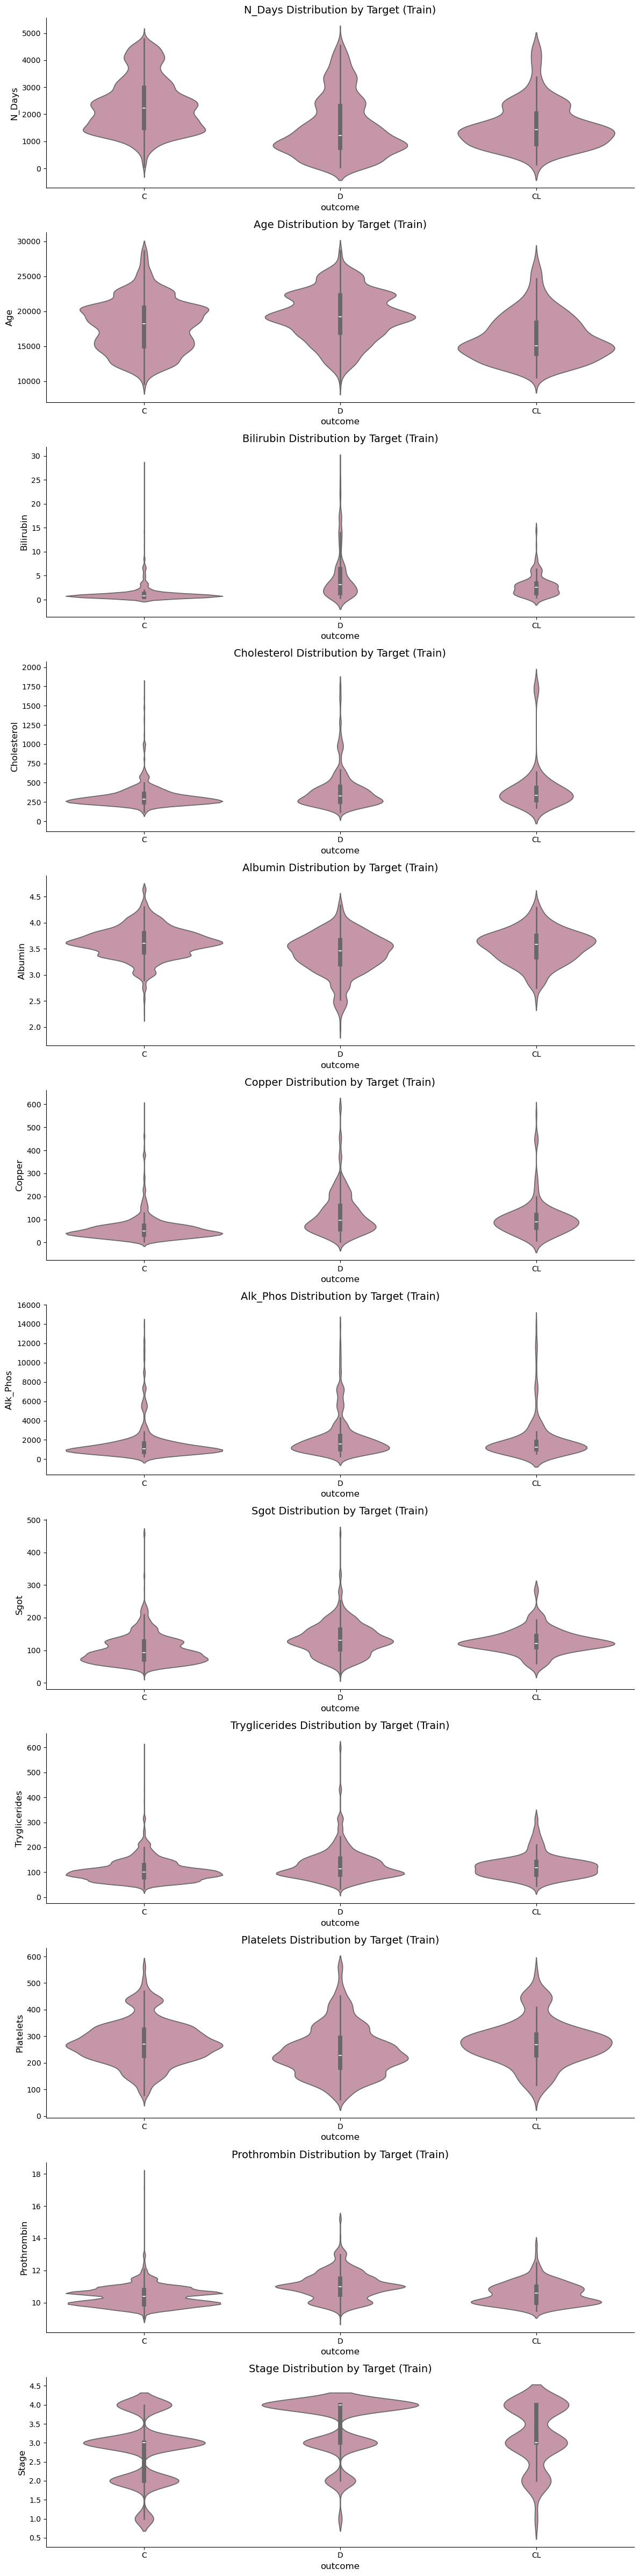

In [86]:
n_rows = len(numeric_cols.columns)
fig, axs = plt.subplots(n_rows, 1, figsize=(12, 4 * n_rows))
sns.set_palette([(0.8, 0.56, 0.65), 'crimson',  (0.99, 0.8, 0.3)])  

for i, col in enumerate(numeric_cols.columns):
    sns.violinplot(x='Status', y=col, data=train_df, ax=axs[i])
    axs[i].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[i].set_xlabel('outcome', fontsize=12)
    axs[i].set_ylabel(col.title(), fontsize=12)
    sns.despine()

fig.tight_layout()

plt.show()

### Categorical Columns

In [77]:
cat_cols = train_df.select_dtypes(include='object')
cat_cols

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
5664,Placebo,F,N,Y,N,N,C
2404,Placebo,F,N,Y,N,N,C
2358,D-penicillamine,F,N,N,N,N,C
1927,Placebo,F,N,N,Y,N,C
1754,Placebo,F,N,Y,N,Y,D
...,...,...,...,...,...,...,...
1863,Placebo,F,N,Y,N,Y,D
3179,D-penicillamine,F,N,N,N,N,C
3530,D-penicillamine,F,Y,Y,Y,Y,D
6885,Placebo,F,N,Y,N,N,C


In [78]:
def value_counts_all_col(df):
    for col in df.columns:
        print(f"Value Counts for : {df[col].value_counts()}\n")


In [79]:
value_counts_all_col(cat_cols)

Value Counts for : Drug
Placebo            3190
D-penicillamine    3134
Name: count, dtype: int64

Value Counts for : Sex
F    5870
M     454
Name: count, dtype: int64

Value Counts for : Ascites
N    6024
Y     300
Name: count, dtype: int64

Value Counts for : Hepatomegaly
Y    3258
N    3066
Name: count, dtype: int64

Value Counts for : Spiders
N    4763
Y    1561
Name: count, dtype: int64

Value Counts for : Edema
N    5718
S     329
Y     277
Name: count, dtype: int64

Value Counts for : Status
C     3965
D     2131
CL     228
Name: count, dtype: int64



* Drug: One-Hot Encoding
* Sex: Label encoding
* Ascites: Label Encoding
* Hepatomegaly: Label Encoding
* Spiders: Label Encoding
* Edema: One-Hot Encoding
* Status: Label Encoding

In [80]:
# Possible Mapping dict
mapping_dicts = {
    'Drug': {'D-penicillamine': 0, 'Placebo': 1},
    'Sex': {'M': 0, 'F': 1},
    'Ascites': {'N': 0, 'Y': 1},
    'Hepatomegaly': {'N': 0, 'Y': 1},
    'Spiders': {'N': 0, 'Y': 1},
    'Edema': {'N': 0, 'Y': 1, 'S': 2},
    'Status': {'D': 0, 'C': 1, 'CL': 2},
}